# System genetics assignment 2

### Setup

In [1]:
import os
import platform
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Read data sources

In [2]:
# Based on the platform choose the file locations
if platform.system() == 'Windows':
	# Rotem's file paths
	genotype_file_path = os.path.normpath('')
	phenotypes_file_path = os.path.normpath('')
else:
	# Carmi's file paths
	genotype_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/genotypes.xls')
	phenotypes_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/phenotypes.xls')
	

genotypes_df = pd.read_excel(genotype_file_path)
chosen_phenotype_df = pd.read_excel(phenotypes_file_path)

In the genotype table, B and D denote parental homozyges individuals and H denotes a heterozygos individual. U are unknows and will therefore be dropped when using their data

Import the Climbing scores after 16 mg/kg i.p. methamphetamine injection [quadrant crossings/min] phenotype from the phenotype table

In [3]:
chosen_phenotype_row = chosen_phenotype_df.loc[chosen_phenotype_df.ID_FOR_CHECK == 172]
# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
chosen_phenotype_row_data_homozygos = chosen_phenotype_row.iloc[:, 7:]

display(chosen_phenotype_row)

,ID_FOR_CHECK,Phenotype,Authors,Year,Pubmed Id,C57BL/6J,DBA/2J,BXD1,BXD2,BXD5,...,BXD94,BXD95,BXD96,BXD97,BXD98,BXD99,BXD100,BXD101,BXD102,BXD103
172,172,Climbing scores after 16 mg/kg i.p. methamphet...,"Grisel JE, Belknap JK, O'Toole LA, Helms ML, W...",1997,8987796.0,2.3,0.6,0.1,-0.8,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def get_phenotype_genotype_df(all_snps_df, chosen_phenotype_df, is_include_heterozygos_genotypes=False):
	'''
	Description
	-----------
	Make a dataframe with snps as their original letter, the numaric represantation of them and the phenotype value.
	The function will always drop "U" - unknown genotypes and if is_include_geterozygos_genotypes=True it will incluse hetezygos (H) individuals as well.
	This function does not change the state of the provided dataframes.

	Parameters
	----------
	all_snps_df : pandas dataframe
		The dataframe containing the individuals and thier genotype as a single letter.
		D and B are homozygos parental genotypes, H is geterozygos and U is unknown.
	chosen_phenotype_df : pandas dataframe
		The dataframe containing the individuals and thier phenotype measurement as a float from the chosen phenotype row (only a single row is expected).
	is_include_heterozygos_genotypes : bool
		if set to True, then heterozygos individuals will be included in the returned matrix

	Returns
	-------
	genotype_phenotype_df : pandas dataframe
		Fields:
			individual : str
				The individual BXD id (ex BXD1)
			snp_locus : str,
				The snp locus indentifier (ex rs6269442)
			snp_chr : int,
				the snp chromosome (1, 2...)
			genotype_letter : str,
				B and D denote parental homozyges individuals and H denotes a heterozygos individual
			genotype_num : int,
				The genotype_letter converted to a number, B=0, H=1, D=2
			phenotype_value : float
				The value of the phenotype to associate as a float
	'''
	chosen_phenotype_df_data = chosen_phenotype_df.copy()
	# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
	chosen_phenotype_df_data = chosen_phenotype_df_data.iloc[:, 7:]
	# As a first step, remove columns from the phenotypes df that have NaN in them.
	# Since we are expecting a single row then this is OK and won't destroy data for other associations.
	chosen_phenotype_df_data = chosen_phenotype_df_data.dropna(axis=1, how='any')

	# Now remove all genotypes for which we do not have a phenotypic measurement
	snps_df = all_snps_df.copy()
	# Split to data and metadata for ease of work
	snps_df_metadata = snps_df.iloc[:, :4]
	snps_df_data = snps_df.iloc[:, 4:]
	# For some reasson there are 'b' values in the file convert them to 'B'
	snps_df_data = snps_df_data.replace('b', 'B')

	# Get the columns to keep
	common_columns = snps_df_data.columns.intersection(chosen_phenotype_df_data.columns)
	snps_df_data = snps_df_data.loc[:, common_columns]
	# Put all the data back into the original dataframe
	snps_df = pd.concat([snps_df_metadata, snps_df_data], axis=1)

	# As the last step of data cleaning set the letters to drop.
	# U is always dropped, and if we aren't keeping heterozygos individuals then remove H as well.
	letters_to_drop = ['U']
	if is_include_heterozygos_genotypes:
		letters_to_drop.append('H')

	snps_df = snps_df.replace(letters_to_drop, pd.NA)

	# Prepare all columns to be saved into a flattened df
	individuals_column = np.tile(snps_df_data.columns, snps_df_data.shape[0])
	locus_column = np.tile(snps_df['Locus'].values.flatten(), snps_df_data.shape[1])
	chr_column = np.tile(snps_df['Chr_Build37'].values.flatten(), snps_df_data.shape[1])
	binary_rep = [ 0 if value == 'B' else (1 if value == 'H' else 2) for value in snps_df_data.values.flatten()]
	phenotypes_column = np.tile(chosen_phenotype_df_data, snps_df_data.shape[0])[0]
	
	
	# Create the final dataframe
	genotype_phenotype_df = pd.DataFrame({
		'individual' : individuals_column,
		'locus' : locus_column,
		'chr' : chr_column,
		'genotype_num' : binary_rep,
		'phenotype_value' : phenotypes_column
	})

	# Since the letter are across many fields it's easier to fill the column this way as opposed to what was done above
	genotype_phenotype_df['genotype_letter'] = genotype_phenotype_df['genotype_num'].apply(lambda x: 'B' if x == 0 else ('H' if x == 1 else 'D'))

	# Move 'phenotype_value' column to the end
	columns = [col for col in genotype_phenotype_df.columns if col != 'phenotype_value'] + ['phenotype_value']
	genotype_phenotype_df = genotype_phenotype_df[columns]


	return genotype_phenotype_df

## Question 1

### Find a locus with hetroziygosity

In [5]:
# Save the locus index found for later use
locus_index = -1
locus_id = ''

for index, row in genotypes_df.iterrows():
	# Exclude the first three columns (Locus, Chr_Build3, Build37_pc)
	alleles = row[3:]
	if 'B' in alleles.values and 'D' in alleles.values and 'H' in alleles.values:
		print(f"SNP {row['Locus']} at row {index} has heterozygosity.")
		locus_index = index
		locus_id = row['Locus']
		break 

SNP rs6269442 at row 0 has heterozygosity.


In [6]:
chosen_snp = genotypes_df.iloc[index]
chosen_snp_data = chosen_snp.values[4:]

In [7]:
genotype_phenotype_df = get_phenotype_genotype_df(genotypes_df, chosen_phenotype_row, is_include_heterozygos_genotypes=True)

### (a) linear regression model in which heterozygous markers are ignored

In [8]:
chosen_snp_df = genotype_phenotype_df.loc[genotype_phenotype_df['locus'] == locus_id]
print(chosen_snp_df.shape)

(24, 6)


In [9]:
# Linear regression implementation goes here

Intercept: 0.46561887462544665
R^2: 0.004045740887475557
P-values (statsmodels): genotype_num    0.0
dtype: float64


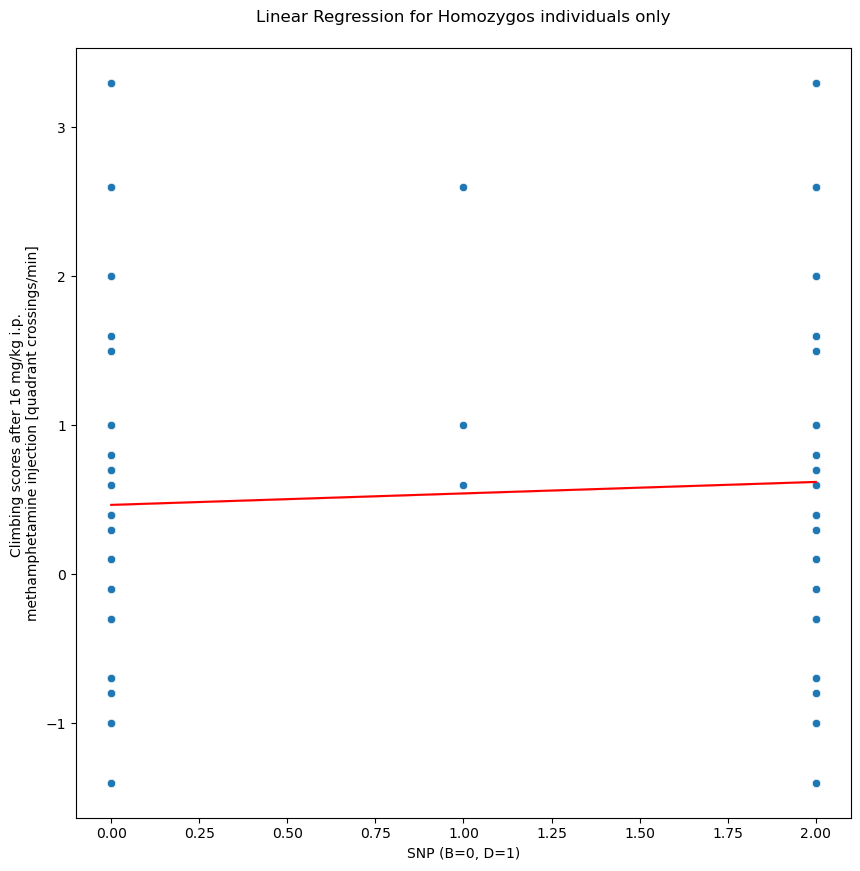

In [10]:
genotype_numbers = genotype_phenotype_df[['genotype_num']]
phenotype_values = genotype_phenotype_df['phenotype_value']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(genotype_numbers, phenotype_values)
r_sqaured = model.score(genotype_numbers, phenotype_values)

print(f"Intercept: {model.intercept_}")
print(f'R^2: {r_sqaured}')

# Save for plotting
genotype_phenotype_df['Predicted_Trait'] = model.predict(genotype_numbers)

X = sm.add_constant(genotype_numbers)
# Fit the model using statsmodels to get the p-value
model_stats = sm.OLS(phenotype_values, genotype_numbers).fit()
print("P-values (statsmodels):", model_stats.pvalues)

# Plot the data and the regression line
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='genotype_num', y='phenotype_value', data=genotype_phenotype_df)
sns.lineplot(x='genotype_num', y='Predicted_Trait', data=genotype_phenotype_df, color='red')
plt.xlabel('SNP (B=0, D=1)')
plt.ylabel('Climbing scores after 16 mg/kg i.p. \nmethamphetamine injection [quadrant crossings/min]')
plt.title('Linear Regression for Homozygos individuals only\n')
plt.show()